In [82]:
import pandas as pd
import os
from collections import defaultdict
%matplotlib inline
import seaborn as sns

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [46]:
aan_loc = '/home/jacobe/data/aan/release/2012'

In [49]:
netfile = os.path.join(aan_loc,'networks/paper-citation-nonself-network.txt')
paperlist = os.path.join(aan_loc,'paper_citations.txt')

In [133]:
def matchPaper(papername,prefix='P'):
    # e.g. P87-1020
    # this second condition selects main conference papers: their numbers start with '1'
    return len(papername) > 4 and papername[0] == prefix and papername[4]=='1'

In [55]:
def get4DigitYearFrom2Digits(year2):
    if int(year2) > 20:
        return 1900 + int(year2)
    return 2000 + int(year2)

In [54]:
papers_per_year = defaultdict(lambda : set)

In [62]:
papers_per_year = defaultdict(lambda : set())
with open(paperlist,'r') as fin:
    for line in fin:
        papername = line.split('\t')[1]
        if matchPaper(papername):
            papers_per_year[get4DigitYearFrom2Digits(papername[1:3])].add(papername)
papers_per_year = {year:len(paperset) for year,paperset in papers_per_year.iteritems()}

In [68]:
from_cites = []
to_cites = []
from_years = []
to_years = []
to_types = []
from_types = []
with open(netfile,'r') as fin:
    for line in fin:
        cite1,_,cite2 = line.rstrip().split()
        if matchPaper(cite2):
            from_cites.append(cite1)
            to_cites.append(cite2)
            from_years.append(get4DigitYearFrom2Digits(cite1[1:3]))
            to_years.append(get4DigitYearFrom2Digits(cite2[1:3]))
            from_types.append(cite1[0])
            to_types.append(cite2[0])

In [99]:
df = pd.DataFrame({'from':from_cites,
                   'to':to_cites,
                   'from_year':from_years,
                   'to_year':to_years,
                   'to_type':to_types,
                   'from_type':from_types})

In [100]:
def getCiteCounts(gap,exact=True):
    years = range(1980,2010)
    num_cited = []
    num_papers = []
    for to_year in years:
        from_year = to_year + gap
        num_cited.append(len(df[(df['to_year']==to_year) 
                           & (df['from_year']==from_year)].groupby('to').groups))
        num_papers.append(papers_per_year[to_year])
    df_out = pd.DataFrame({'year':years,'num_papers':num_papers,'num_cited':num_cited})
    df_out['cite_rate'] = df_out['num_cited']/df_out['num_papers']
    return df_out

In [105]:
df3 = getCiteCounts(3,exact=True)

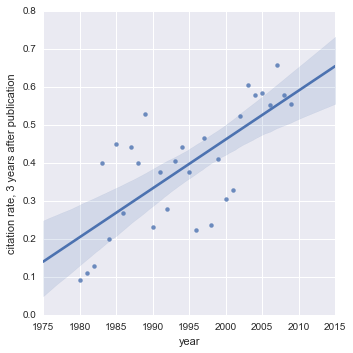

In [106]:
ax = sns.lmplot(x='year',y='cite_rate',data=df3);
ax.set_ylabels('citation rate, 3 years after publication')
sns.despine()

In [126]:
for base_year in range(1980,1992):
    print base_year, len(df[(df['to_year']==base_year) & (df['from_year']>base_year+20)]['to'].unique())

1980 2
1981 3
1982 3
1983 10
1984 20
1985 10
1986 3
1987 8
1988 13
1989 11
1990 5
1991 6


In [127]:
def getSurvivalRates(max_gap=10):
    years = range(1980,2012)
    num_cited = [0]*max_gap
    num_papers = [0]*max_gap
    for to_year in years:
        for gap in range(min(max_gap,max(years)-to_year)):
            from_year = to_year + gap
            num_cited[gap] += len(df[(df['to_year']==to_year) & (df['from_year']>from_year)]['to'].unique())
            num_papers[gap] += papers_per_year[to_year]
    df_out = pd.DataFrame({'gap':range(max_gap),'num_papers':num_papers,'num_cited':num_cited})
    df_out['cite_rate'] = df_out['num_cited']/df_out['num_papers']
    return df_out

In [131]:
df_survive = getSurvivalRates(max_gap=21)

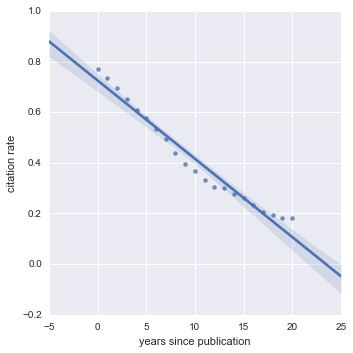

In [132]:
ax = sns.lmplot(x='gap',y='cite_rate',data=df_survive)
ax.set_ylabels('citation rate')
ax.set_xlabels('years since publication');